<a href="https://colab.research.google.com/github/AnalystGagan/Project-dog-vision/blob/master/Project_dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐶 End-to-End Multi-Class Dog Breed Classification

This notebook builds an End-to-end Multi-Class Image Classifier using Tensorflow Hub.


## 1.Problem
Identifying the breed of a dog given an image of a dog

When I am sitting at the Starbucks and I take a photo of a dog, want to know what breed of a dog it is. 
## 2.Data 
The data we are using is from Kaggel's dog breed identification compitition 

https://www.kaggle.com/c/dog-breed-identification/data
## 3.Evaluation
The Evaluation is a file with prediction probabilities for each dog breed of each test Image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation
## 4.Features
Some information about the data:

* we are dealing with images (unstructured data ) so it is probably best se use deep learning/ transfer learning. 
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in training dataset (These images has labels)
* There are around 10,000+ images in test dataset (These images do not have labels, becasue we'll want to predict them).





In [ ]:
# Unzip the uploaded data into google Drive

#!unzip "drive/My Drive/dog-vision-data/dog-breed-identification.zip" -d "drive/My Drive/dog-vision-data/"

### Getting our workspace ready 

* Import TensorFlow 2.x ✔️
* Import TensorFlow Hub ✔️
* Make sure we are using a GPU ✔️


In [ ]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print("TF version :", tf.__version__)
print("TF Hub version:",hub.__version__)

# Check for GPU availablity 
print("GPU","available (Yessssssss!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version : 2.2.0
TF Hub version: 0.8.0
GPU available (Yessssssss!!!!)


## Getting our data ready (Turning into Tensors)

With all Machine Leanring models, our data has to be in numerical format. So that's what we will be doing first. Turning our images into Tensors(numerical representations)

Let's start by accessing our data and checking out checking out the labels.

In [ ]:
# Checkout the labels of our data 
import pandas as pd 
# Path --> /content/drive/My Drive/dog-vision-data/labels.csv
labels_csv = pd.read_csv("drive/My Drive/dog-vision-data/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     6887d854847cdc1bbbcc7529c0b93473  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [ ]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
# How many images are there of each breed
labels_csv["breed"].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
komondor                 67
brabancon_griffon        67
golden_retriever         67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

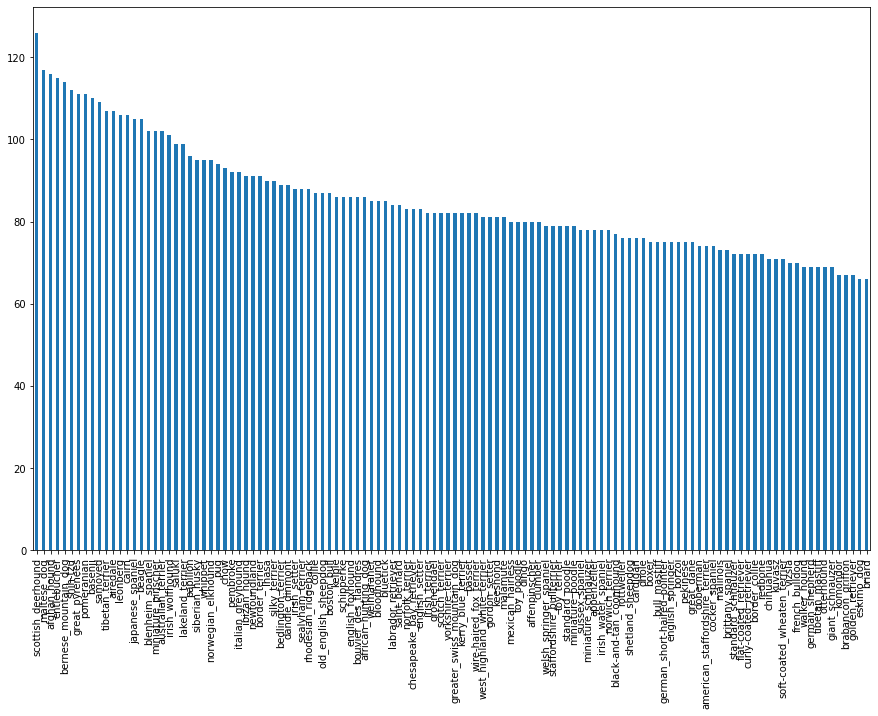

In [ ]:
labels_csv["breed"].value_counts().plot.bar(figsize = (15,10));

In [ ]:
labels_csv["breed"].value_counts().median()

82.0

*** Good start, our dataset is balance accross each class of breed. 
Google recommends minimum number of images per class should be 10*** 
https://cloud.google.com/vision/automl/object-detection/docs/prepare

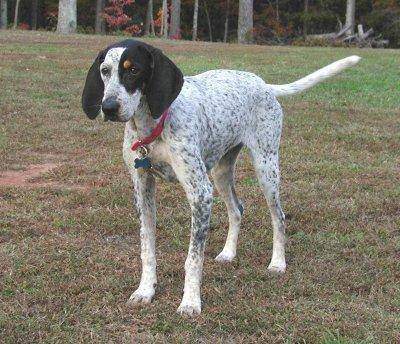

In [ ]:
# Let's view an image 
from IPython.display import Image
Image("drive/My Drive/dog-vision-data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg")

### Getting images and their labels 

Let's get a list of all of our image file pathnames. 

In [ ]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
# Create a path name from image ID's 
filename = ["drive/My Drive/dog-vision-data/train/"+fname + ".jpg" for fname in labels_csv["id"]]

# Check for the first 10
filename[:10]

['drive/My Drive/dog-vision-data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/dog-vision-data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/dog-vision-data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/dog-vision-data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/dog-vision-data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/dog-vision-data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/dog-vision-data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/dog-vision-data/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/dog-vision-data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/dog-vision-data/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [ ]:
# Check wheather number of filename matches with number of actual image files
import os 
if len(os.listdir("drive/My Drive/dog-vision-data/train/")) == len(filename):
  print("filename matches  actual numeber of files, Proceed")
else:
  print("filename donot match actual amount of files, check the target directory")


filename matches  actual numeber of files, Proceed


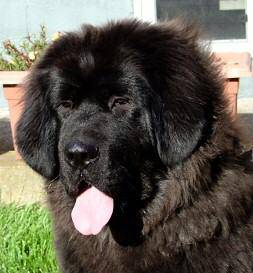

In [ ]:
# One more check 
Image(filename[998])

In [ ]:
# Great!! Now, lets find out the breed of this dog 
labels_csv["breed"][999]


'irish_wolfhound'

Since we have now got our training image filepath in a list, let's prepare our labels

In [ ]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
#labels = np.array(lables) # does the same thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
len(labels)

10222

In [ ]:
# See if the number of labels matches with number of filenames 
if len(labels) == len(filename):
  print("Number of labels matches with number of file names ")
else:
  print("Number of labels does not match with number of file names")

Number of labels matches with number of file names 


In [ ]:
# Find the unique label vlaues
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [ ]:
len(unique_breeds)

120

In [ ]:
# Turn a single label into an array of boolens
print(labels[0])
labels[0] == unique_breeds


boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
# Tuen evey label into boolen array
boolen_labels = [label == unique_breeds for label in labels]
boolen_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
len(boolen_labels)

10222

In [ ]:
# Example: Turing boolen array into integers
print(labels[0]) # Original label
print(np.where(unique_breeds == labels[0])) # index where labels occurs
print(boolen_labels[0].argmax()) # index where label occurs in boolen array
print(boolen_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [ ]:
print(labels[2])
print(boolen_labels[2].astype(int))


pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]






 ### Creating our own Validation set 
 Since, the dataset from kaggel does not come with a validation set, we are going to create our own

In [ ]:

# Setup X and y variables

X = filename
y = boolen_labels

We are going to start off experimenting with ~1000 images and increase as needed

In [ ]:
# Set the number of images to use for experimenting 
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [ ]:
# Let's split our data into train and validation sets
from sklearn .model_selection import train_test_split
# np.random.seed(42)
# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES], test_size = 0.2, random_state = 42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [ ]:
# lets have a look at training data
X_train[:2], y_train[:2]

(['drive/My Drive/dog-vision-data/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/dog-vision-data/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False

## Preprocessing Images (Turning Images into Tensors)

To preprocess our Images into Tensors . we're going to write a function which does a few things: 

1. Take the image filepath as input
2. Use Tensorflow to read the file and save it to a variable, `image`
3. Turn our `image` jpg into Tensors 
3. Resize the `image` to be a shape of (224,224)
4. Return the modified `image`

Before we do, lets see what importing an image looks like.

In [ ]:
# Convert Image to NumPy array 
from matplotlib.pyplot import imread
image = imread(filename[42])
image.shape
# Image is a combinatiomn of red,green and blue pixel values

(257, 350, 3)

In [ ]:
image.max(), image.min()

(255, 0)

In [ ]:
# Turn image into a Tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

Now, we have seen what an image looks like as a Tensor, let's make a function to preprocess them. 

1. Take the image filepath as input
2. Use Tensorflow to read the file and save it to a variable, image
3. Turn our image jpg into Tensors
4. Normalize our image (convert color channel value from 0-255 to 0-1).
5. Resize the image to be a shape of (224,224)
6. Return the modified image

In [ ]:
# Define image size
IMG_SIZE = 224

# Create a function to preprocess images 
def process_image(image_path, img_size = IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor.
  """
  # Read in an Image file 
  image = tf.io.read_file(image_path)
  # Turn the Jpeg image into numerical Tensor with 3 color channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the color channel values from 0-255 to 0-1 values 
  image = tf.image.convert_image_dtype(image, tf.float32) # data normalization
  # Resize the image to our desire value (224,224)
  image= tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image


### Turning our data into batches 

Why turn our data into batches 

Let's say you are trying to process 10,000+ images in one go... they all might not fit into memory. 

So that is why we do about 32 (this is the batch size)  images at a time( you can manually adjust the batch size if need be).

https://twitter.com/ylecun/status/989610208497360896?s=20

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this:
`(image, label)`




In [ ]:
# Create a simple function to return a tuple (image, label) 
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [ ]:
# Demo of the above 
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now, we have got a way to turnb our data into tuple of Tensors in the form `image, label`. Let's make a function to turn all of our data (`X`& `y`) into batches

In [ ]:
# Define a batch size , 32 is a good start 
BATCH_SIZE = 32

# Create a function to turn data into batches 

def create_data_batches(X, y=None, batch_size = BATCH_SIZE, valid_data = False, test_data = False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it is training data but does not shuffle if it is validation data.
  Also, accepts test data as input (no lables)
  """
  # If data is a test dataset, we probably do not have labels 
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepath no label
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # if data is a valid dataset, we don't need to shuffle it 
  elif valid_data: 
    print(" Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths 
                                               tf.constant(y))) #lables
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)  
    return data_batch
  else: 
    print("Creating training data batches.... ")
    # Turn filepath and label into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                              tf.constant(y)))

    # Shuffeling pathname nad labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size = len(X)) 

    # Create (image, label) tuples (this also turns the images path into a preprocessed image) 
    data = data.map(get_image_label)   

    # Turn the training data into batches 
    data_batch = data.batch(BATCH_SIZE)
           
    return data_batch                              
  


In [ ]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
valid_data = create_data_batches(X_val, y_val, valid_data=True )


Creating training data batches.... 
 Creating validation data batches...


In [ ]:
# Check out the different attributes of our data batches
train_data.element_spec, valid_data.element_spec


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Our data in now in batches , however these can be a little hard to understand/ comprehend , Let's visualize them 

In [ ]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Setup the figure 
  plt.figure(figsize =(10,10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
  # Create subplots (5 rows, 5 columns)
   ax = plt.subplot(5,5,i+1)
  # Display an image 
   plt.imshow(images[i])
  # Add the image label as the tile 
   plt.title(unique_breeds[labels[i].argmax()])
  # Turn the grid lines off
   plt.axis("off")



In [ ]:
train_images, train_labels = next(train_data.as_numpy_iterator())
len(train_images), len(train_labels)

(32, 32)

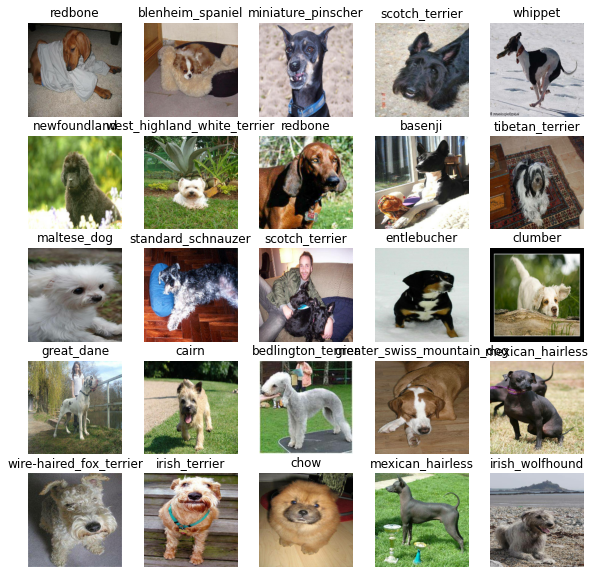

In [ ]:
# Now let's visualize the data in a training batch
show_25_images(train_images, train_labels)

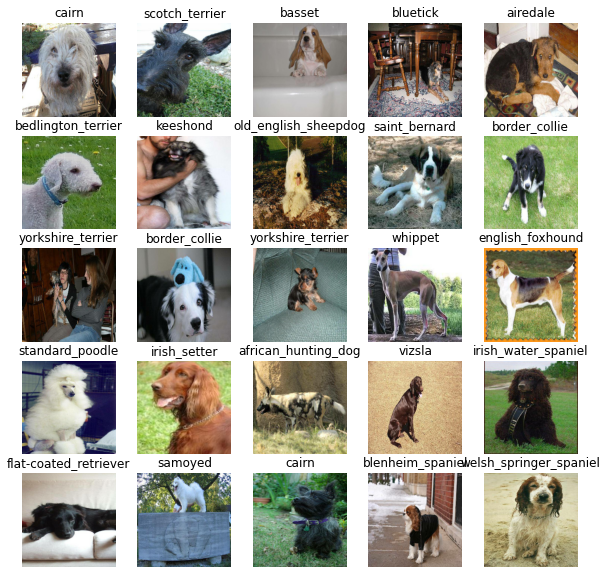

In [ ]:
# Now let's visualize our valuization set 
val_images, val_labels = next(valid_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

##  Building a model 

Before we build a model, there are a few things we need to define:
* The input shape (our images shape, in the from of Tensors) to our model. 
* The output shape( image labels, in the form of Tensors) of our model. 
* The URL of them model we want to use. 


In [ ]:
# Setup input shape to the model 
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height , eidth , colour channels

# Setup output shape of our model
OUTPUT_SHAPE  = len(unique_breeds) 

# Setup model URL from TensorFlow hub 
MODEL_URL = ...